# DIABETES RETINOPATHY
malattia degli occhi che può occorrere ai diabetici. scopo dello studio è riuscire a allenare una rete che riconosca gli occhi malati o sani con una certa confidenza

# Load Data from disk
andiamo a caricare il nostro set di dati (immagini) di occhi diabetici

*Importo librerie utili*

In [1]:
%pylab inline
import pandas as pd
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


*Le immagini sono gia su disco, conto il numero totale di immagini nel dataset*

In [2]:
from os import listdir #This module provides a portable way of using operating system dependent functionality


path = "/home/gdeandrea/Scrivania/Diabete/DatiCurati/retinopathy-dataset"
train_dir = path + '/train_set'
validation_dir = path + '/validation_set'

num_sympt_train = len(listdir(train_dir + '/symptoms/'))
num_nosympt_train = len(listdir(train_dir + '/nosymptoms/'))
num_sympt_validation = len(listdir(validation_dir + '/symptoms/'))
num_nosympt_validation = len(listdir(validation_dir + '/nosymptoms/'))

print('N° casi sintomatici: ', num_sympt_train + num_sympt_validation + num_nosympt_train + num_nosympt_validation)
print('N° casi sintomatici: ', num_sympt_train + num_sympt_validation)
print('N° casi asintomatici: ', num_nosympt_train + num_nosympt_validation)
print('----')
print('N° casi training: ', num_nosympt_train + num_sympt_train)
print('N° casi sintomatici training: ', num_sympt_train)
print('N° casi asintomatici training: ', num_nosympt_train)
print('----')
print('N° casi validation: ', num_nosympt_validation + num_sympt_validation)
print('N° casi sintomatici validation: ', num_sympt_validation)
print('N° casi asintomatici validation: ', num_nosympt_validation)

N° casi sintomatici:  2063
N° casi sintomatici:  595
N° casi asintomatici:  1468
----
N° casi training:  1547
N° casi sintomatici training:  448
N° casi asintomatici training:  1099
----
N° casi validation:  516
N° casi sintomatici validation:  147
N° casi asintomatici validation:  369


*Creo generatori che riscalano i miei dati*

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#ImageDataGenerator()
#ImageDataGenerator().flow_from_directory()
train_image_generator = ImageDataGenerator(rescale=1./255)

validation_image_generator = ImageDataGenerator(rescale=1./255)

*Uso methodo che carica le immagini e ci applica le trasformazioni che ho impostato con ImageDataGenerator()*

In [4]:
batch_size = 15
IMG_HEIGHT = 222
IMG_WIDTH = 222

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

#nel caso avessi avuto i dati non divisi, avrei potuto evitare la divisione in train e validation con ImageDataGenerator(validation_split = 0.2) 

Found 1547 images belonging to 2 classes.
Found 516 images belonging to 2 classes.


*Guardo il tipo di dati in uscita e con funzione **next** ne prendo 15 con relative labels come esempio*


*Verifico che siano effettivamente immagini 222x222 con 3 canali colore (RGB)*



*Plotto poi gli esempi*

In [5]:
print(train_data_gen)
sample_training_images, sample_training_labels = next(train_data_gen) #next prende 15 elementi dell'iteratore train_data_gen (immagini -> s_tr_imgs) con relative labels (s_tr_lbls)
sample_training_images[1].shape

(222, 222, 3)

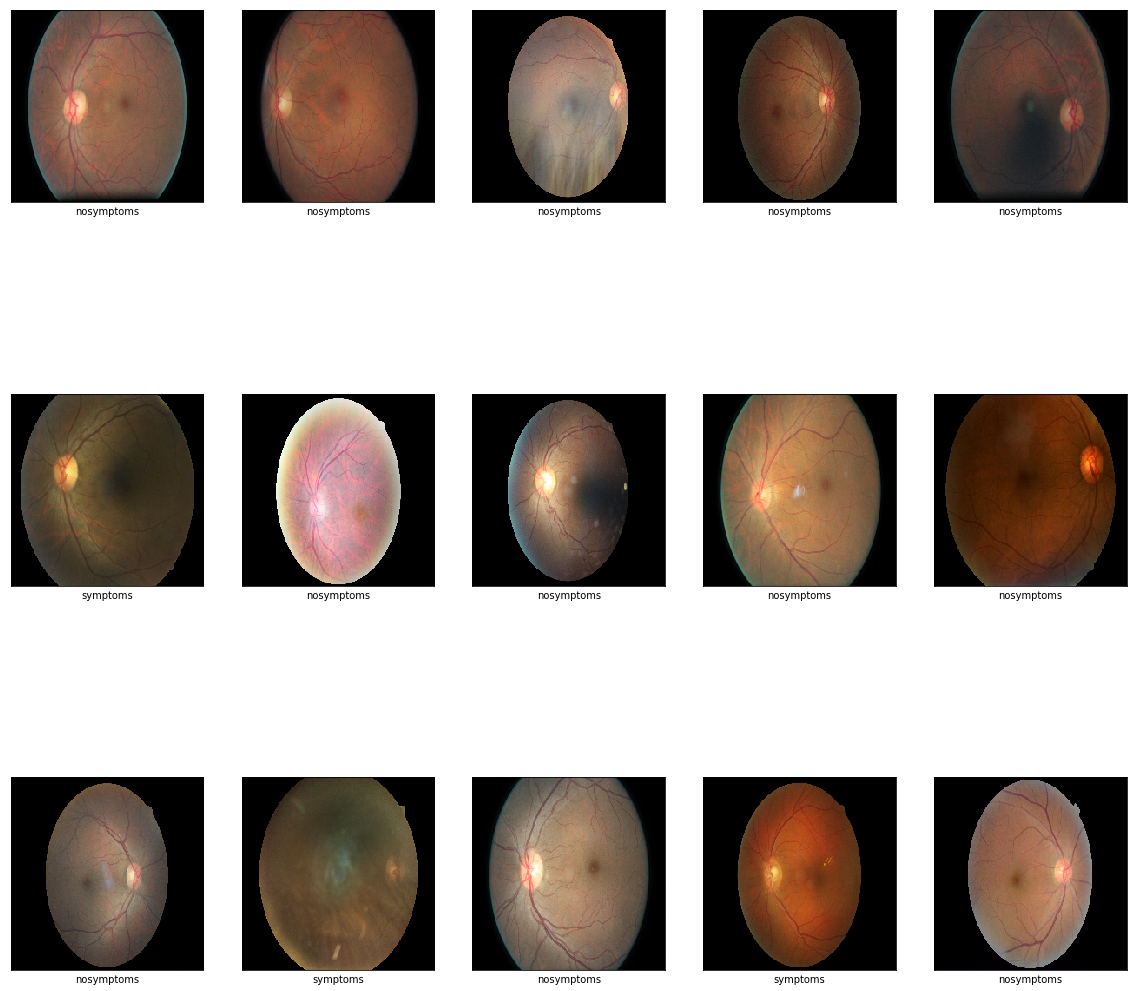

In [6]:
sample_training_values = []
sample_training_values.append('nosymptoms')
sample_training_values.append('symptoms')

plt.figure(figsize=(20,20))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_training_images[i], cmap=plt.cm.binary)

    plt.xlabel(sample_training_values[int(sample_training_labels[i])])
plt.show()


# Data Augmentation
*Noto che le foto sono tra loro molto diverse per esposizione, colore, zoom etc. Per prevenire overfitting e "normalizzare" i dati andremo a creare duplicati delle immagini di **train** applicando trasformazioni di zoom, colore, esposizione etc. Le immagini di validation sono già pronte*

*Mantengo comunque due data set separati in moddo da analizzare poi le differenze di performance*

*Genero il nuovo trasformatore*

In [18]:
ImageDataGenerator()


aug_train_image_generator = ImageDataGenerator(
    brightness_range = (0.5,1.5), #1 è no brightness change
    #width_shift_range = 0.3,
    #height_shift_range = 0.3,
    zoom_range = 0.2,
    horizontal_flip=True,
    rescale = 1./255)

*Trasformo le immagini*

In [19]:
IMG_HEIGHT = 222
IMG_WIDTH = 222

aug_train_data_gen = aug_train_image_generator.flow_from_directory(directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 1547 images belonging to 2 classes.


*Creo un batch da 15 esempi e le plotto*

In [20]:
print(aug_train_data_gen)
aug_sample_training_images, aug_sample_training_labels = next(aug_train_data_gen) #next prende 15 elementi dell'iteratore train_data_gen (immagini -> s_tr_imgs) con relative labels (s_tr_lbls)
aug_sample_training_images[1].shape

(222, 222, 3)

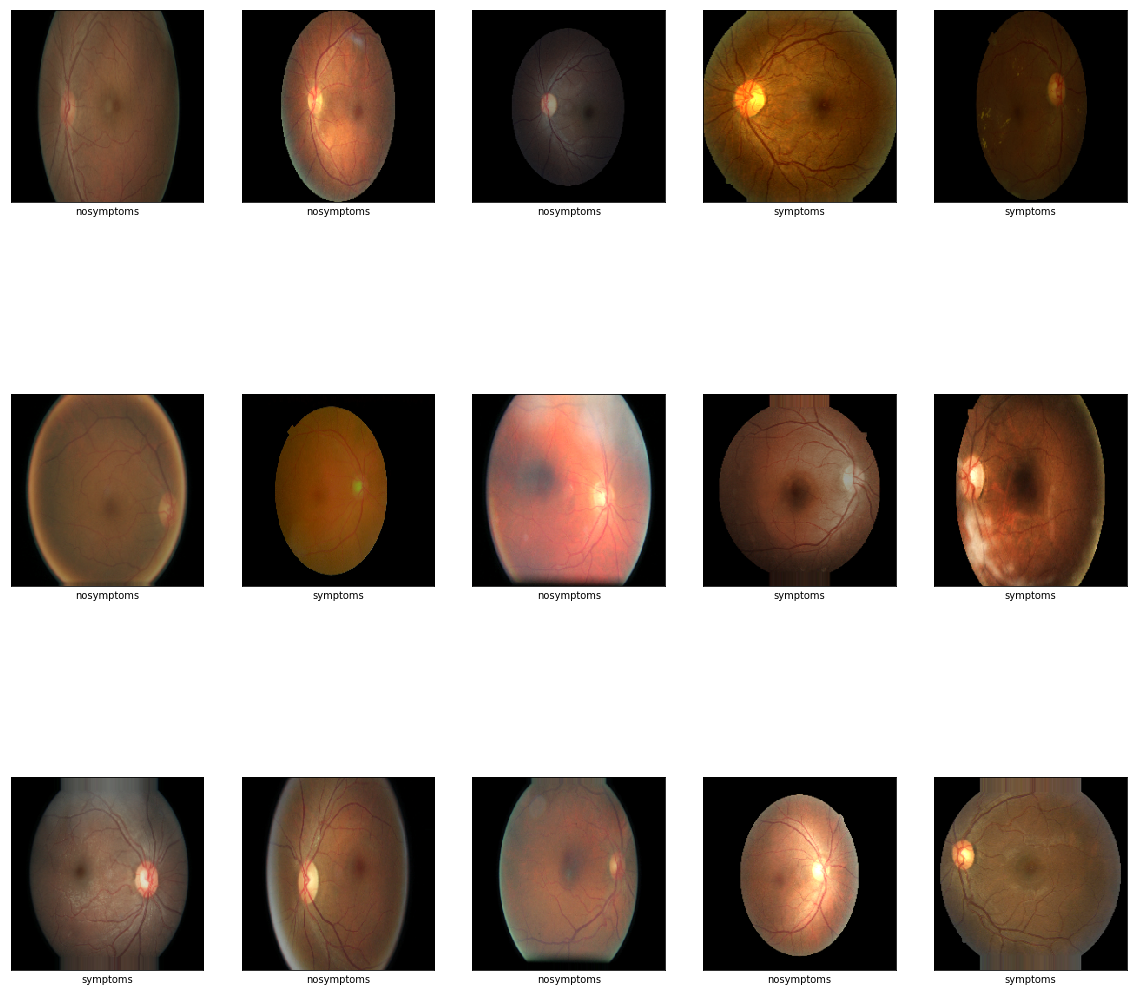

In [21]:
sample_training_values = []
sample_training_values.append('nosymptoms')
sample_training_values.append('symptoms')

plt.figure(figsize=(20,20))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(aug_sample_training_images[i], cmap=plt.cm.binary)

    plt.xlabel(sample_training_values[int(aug_sample_training_labels[i])])
plt.show()

# Baseline Model

In [22]:
len(val_data_gen)

35

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D

#Dropout è regolarizzazione
#Flatten trasforma in 1-d per Dense
#Conv2D processa i dati dell'immagine Conv2D(noutput,(altezza,larghezza),...)
#MaxPooling2D riduce l'output space di Conv2D

*Definisco il modello base*

In [24]:
n_classes = 2

#Stack layers
model = Sequential()
model.add(Convolution2D(30, (5, 5), padding='valid', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Convolution2D(15, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

#Compile model
model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 218, 218, 30)      2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 15)      4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 15)        0         
_________________________________________________________________
dropout (Dropout)            (None, 53, 53, 15)        0         
_________________________________________________________________
flatten (Flatten)            (None, 42135)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5393408   
__________

## Test the model on non augmented data

In [28]:
tot_train = num_nosympt_train + num_sympt_train
tot_validation = num_nosympt_validation + num_sympt_validation
batch_size = 100
steps_per_epoch = tot_train // batch_size
validation_steps = tot_validation // batch_size
epochs = 10
#model.fit_generator()
# Fit the model
history = model.fit_generator(train_data_gen,
                              validation_data=val_data_gen,
                              validation_steps=validation_steps,
                              epochs=epochs,
                              steps_per_epoch=steps_per_epoch,
                              verbose=2)



Epoch 1/10
35/35 [==============================] - 52s 1s/step - loss: 0.8341 - acc: 0.3643
 - 222s - loss: 0.8305 - acc: 0.5087 - val_loss: 0.8341 - val_acc: 0.3643
Epoch 2/10
35/35 [==============================] - 49s 1s/step - loss: 0.8326 - acc: 0.5194
 - 200s - loss: 0.8305 - acc: 0.4874 - val_loss: 0.8326 - val_acc: 0.5194
Epoch 3/10
35/35 [==============================] - 50s 1s/step - loss: 0.8298 - acc: 0.6279
 - 215s - loss: 0.8305 - acc: 0.5068 - val_loss: 0.8298 - val_acc: 0.6279
Epoch 4/10
35/35 [==============================] - 50s 1s/step - loss: 0.8312 - acc: 0.3178
 - 206s - loss: 0.8284 - acc: 0.5010 - val_loss: 0.8312 - val_acc: 0.3178
Epoch 5/10
35/35 [==============================] - 52s 1s/step - loss: 0.8326 - acc: 0.3624
 - 215s - loss: 0.8305 - acc: 0.5087 - val_loss: 0.8326 - val_acc: 0.3624
Epoch 6/10
35/35 [==============================] - 51s 1s/step - loss: 0.8312 - acc: 0.3101
 - 210s - loss: 0.8284 - acc: 0.4861 - val_loss: 0.8312 - val_acc: 0.310

*Plot the results*

In [44]:
history.history

{'loss': [0.8292806826257366,
  0.829280668947877,
  0.829280662590562,
  0.8292806714137446,
  0.8292806627832079,
  0.829280669988165,
  0.8292806641317292,
  0.8292806615888032,
  0.8292806566185387,
  0.8292806687552311],
 'acc': [0.49385908,
  0.4473174,
  0.48157725,
  0.47511312,
  0.4783452,
  0.48351648,
  0.51648355,
  0.51066583,
  0.4848093,
  0.50161606],
 'val_loss': [0.831219836643764,
  0.832648411818913,
  0.832648411818913,
  0.832648411818913,
  0.8326484135219029,
  0.8326484050069537,
  0.8312198383467538,
  0.8297912665775844,
  0.834076976776123,
  0.8312198315347944],
 'val_acc': [0.27131784,
  0.18217054,
  0.13372093,
  0.3139535,
  0.29651162,
  0.30620155,
  0.4011628,
  0.38178295,
  0.45348838,
  0.26744187]}

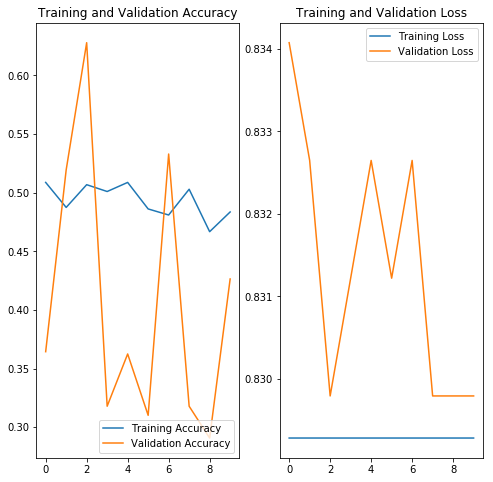

In [40]:
epochs = 10

acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


*I risultati non sono incoraggianti*

## Test model on augmented data

In [41]:
aug_history = model.fit_generator(aug_train_data_gen,
                              validation_data=val_data_gen,
                              validation_steps=validation_steps,
                              epochs=epochs,
                              steps_per_epoch=steps_per_epoch,
                              verbose=2)

Epoch 1/10
35/35 [==============================] - 55s 2s/step - loss: 0.8312 - acc: 0.2713
 - 253s - loss: 0.8288 - acc: 0.4939 - val_loss: 0.8312 - val_acc: 0.2713
Epoch 2/10
35/35 [==============================] - 55s 2s/step - loss: 0.8326 - acc: 0.1822
 - 213s - loss: 0.8282 - acc: 0.4473 - val_loss: 0.8326 - val_acc: 0.1822
Epoch 3/10
35/35 [==============================] - 55s 2s/step - loss: 0.8326 - acc: 0.1337
 - 210s - loss: 0.8294 - acc: 0.4816 - val_loss: 0.8326 - val_acc: 0.1337
Epoch 4/10
35/35 [==============================] - 54s 2s/step - loss: 0.8326 - acc: 0.3140
 - 205s - loss: 0.8282 - acc: 0.4751 - val_loss: 0.8326 - val_acc: 0.3140
Epoch 5/10
35/35 [==============================] - 56s 2s/step - loss: 0.8326 - acc: 0.2965
 - 208s - loss: 0.8282 - acc: 0.4783 - val_loss: 0.8326 - val_acc: 0.2965
Epoch 6/10
35/35 [==============================] - 56s 2s/step - loss: 0.8326 - acc: 0.3062
 - 209s - loss: 0.8294 - acc: 0.4835 - val_loss: 0.8326 - val_acc: 0.306

*Plotto i dati*

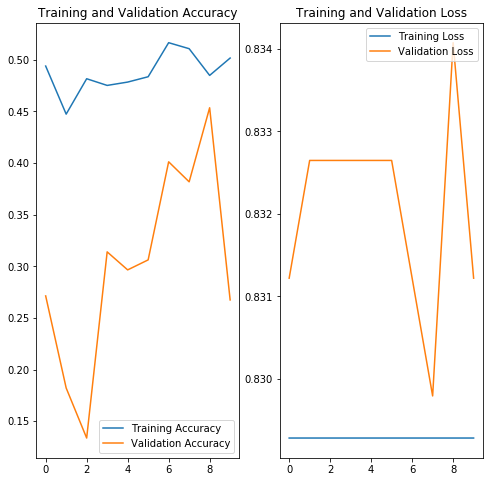

In [43]:
epochs = 10

acc = aug_history.history['acc']
val_acc = aug_history.history['val_acc']

loss=aug_history.history['loss']
val_loss=aug_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*Dovrei sicuramente provare ad allungare le epochs per vedere se effettivamente il trend apparentemente ascendente per acc e val_acc si conferma*